**Membres du groupe**

- valentin.berlier
- léa.masselles
- apolline.wasik

# Présentation du problème

La startup Carotte 4.0 a besoin de notre aide ! Il est de notre devoir de développer une pipeline de classification d'images hyperspectrales, pour étudier l'évolution de l'occupation des sols en milieu urbain et rural, afin de prouver durant la prochaine réunion avec les décideurs de l'ESA et les investisseurs de la start-up que nous somme capables de proposer des solutions innovantes.
A partir des images hyperspectrales, ainsi que des vérités terrain, des sites Indiana Pines et Salinas aux Etats-Unis, nous avons développé une pipeline de classification d'images hyperspectrales.

# Notre solution

In [36]:
# Tous les "import" dont nous avons besoin (excepté OpenCV)
import sklearn as sk
import numpy as np
import seaborn as sn
import pandas as pd
import datetime
from datetime import datetime

from matplotlib import pyplot as plt
from timeit import default_timer as timer

import skimage.morphology
import sklearn.decomposition
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

# <font color='red'>1 - </font> Chargement des images hyperspectrales

In [2]:
indianapines = np.load('indianapines.npy')
indianapines_gt = np.load('indianapines_gt.npy')

salinas = np.load("salinas.npy")
salinas_gt = np.load("salinas_gt.npy")

In [3]:
print("idianapines shape :", indianapines.shape)
print("indianapines_gt shape :", indianapines_gt.shape)

print("salinas shape :", salinas.shape)
print("salinas_gt shape", salinas_gt.shape)

idianapines shape : (145, 145, 200)
indianapines_gt shape : (145, 145)
salinas shape : (512, 217, 204)
salinas_gt shape (512, 217)


##  <font color='red'>1 - 1</font> Normalisation

In [4]:
indianapines = indianapines / indianapines.max()
salinas = salinas / salinas.max()

## <font color='red'>1 - 2</font>  RBG

In [5]:
def get_rgb_img(hyper_img):
    row, col, dim = hyper_img.shape
    print('Data cube has %d rows, %d columns and %d bands'%(row,col,dim))
    rgb_bands = np.array([30,15,2]) # d'après l'énoncé du projet
    img_rgb = hyper_img[:,:,rgb_bands]
    return img_rgb

Data cube has 145 rows, 145 columns and 200 bands
Data cube has 512 rows, 217 columns and 204 bands


<Figure size 432x288 with 0 Axes>

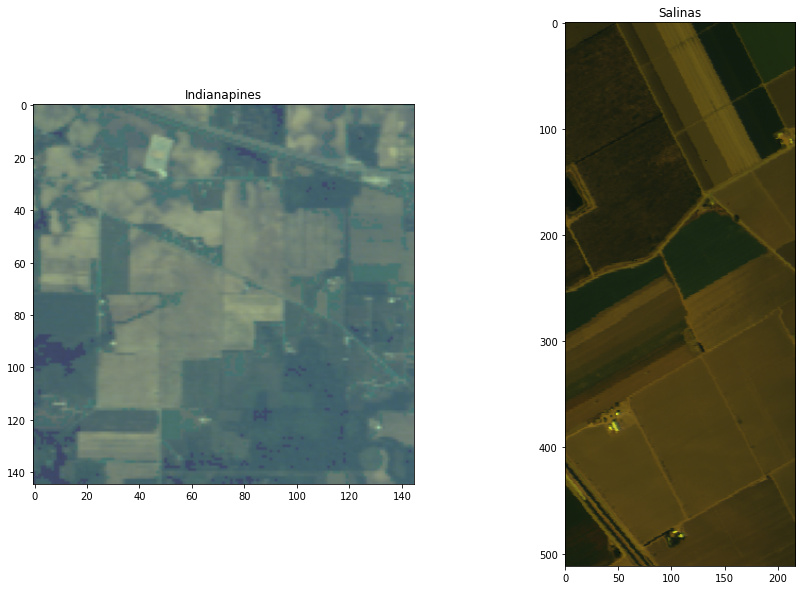

<Figure size 432x288 with 0 Axes>

In [6]:
indianapines_rgb = get_rgb_img(indianapines)
salinas_rgb = get_rgb_img(salinas)

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(indianapines_rgb)
plt.title("Indianapines")

plt.subplot(1,2,2)
plt.imshow(salinas_rgb)
plt.title("Salinas")
plt.figure()

Ce ne sont pas les images les plus jolies... Il est possible de faire mieux.

##  <font color='red'>1 - 3</font> RBG ++

In [7]:
def pimp_rgb(img):
    pmin, pmax = np.percentile(img,(1,99),axis=(0,1))
    rgb_pimped = img.copy()
    for i in range(pmin.size):
        rgb_pimped[:,:,i] = (img[:,:,i] - pmin[i]) / (pmax[i] - pmin[i])
    rgb_pimped[rgb_pimped < 0] = 0
    rgb_pimped[rgb_pimped > 1] = 1
    return rgb_pimped

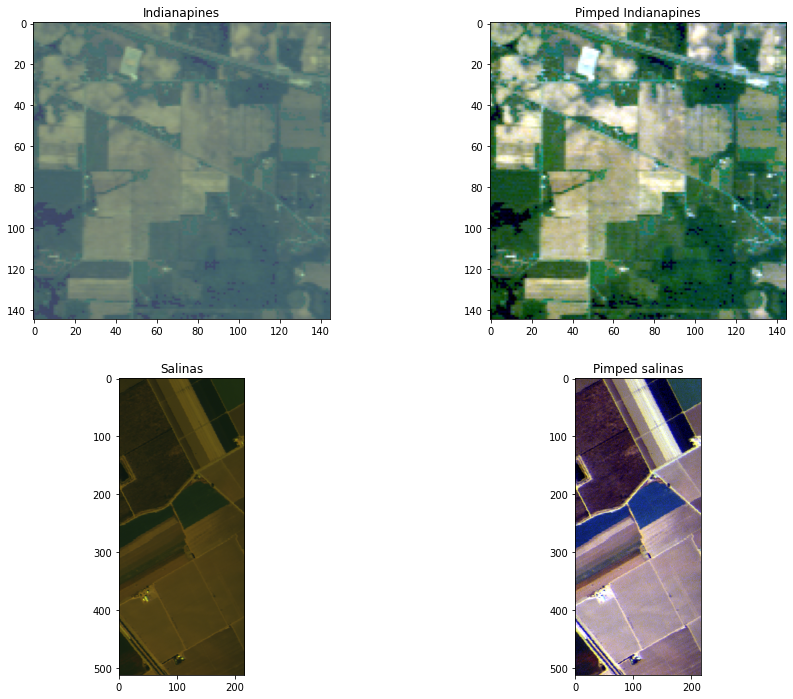

In [8]:
indianapines_pimped = pimp_rgb(indianapines_rgb)
salinas_pimped = pimp_rgb(salinas_rgb)

plt.figure(figsize=(15, 12))
plt.subplot(2,2,1)
plt.title("Indianapines")
plt.imshow(indianapines_rgb)

plt.subplot(2,2,2)
plt.title("Pimped Indianapines")
plt.imshow(indianapines_pimped)

plt.subplot(2,2,3)
plt.title("Salinas")
plt.imshow(salinas_rgb)

plt.subplot(2,2,4)
plt.title("Pimped salinas")
plt.imshow(salinas_pimped)

Cette fois-ci, nos images sont beaucoup plus agréables à regarder et il est bien plus facile de distinguer les différents champs que nous allons classifier.

##  <font color='red'>1 - 4</font> Ajout de coordonnées (x,y)

In [9]:
def add_xy_coord(img):
    nx, ny = img.shape[1], img.shape[0]
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    x = x / nx
    y = y / ny
    xv, yv = np.meshgrid(x,y)
    img_seg = img / img.max()
    img_seg = np.insert(img_seg, 1, xv, axis=-1)
    img_seg = np.insert(img_seg, 1, yv, axis=-1)
    return img_seg

In [10]:
indianapines_seg = add_xy_coord(indianapines)
salinas_seg = add_xy_coord(salinas)

In [11]:
print("indianapines_seg shape : " , indianapines_seg.shape)
print("salinas_seg shape : " , salinas_seg.shape)

indianapines_seg shape :  (145, 145, 202)
salinas_seg shape :  (512, 217, 206)


# <font color='red'>2 - </font> Préparation des données pour des entraînements suppervisés

##  <font color='red'>2-1</font> Dictionnaires

Nous avons "traduit" en dictionnaire Python les données d'Indiana Pines et de Salinas, comprenant la répartition des classes de la vérité terrain, ainsi que le nombre d'échantillons par classe.

In [12]:
indianapines_dict = {
    "alfalfa" : 46,
    "corn-notill": 1428,
    "corn-mintill": 830,
    "corn": 237,
    "grass-pasture": 483,
    "grass-trees": 730,
    "grass-pasture-mowed": 28,
    "hay-windrowed": 478,
    "oats": 20,
    "soybean-notill": 972,
    "soybean-mintill": 2455,
    "soybean-clean": 593,
    "wheat": 205,
    "woods": 1265,
    "buildings-grass-trees-drives": 386,
    "stone-steel-towers": 93
}

In [13]:
salinas_dict = {
    "brocoli_green_weeds_1" : 2009,
    "brocoli_green_weeds_2" : 3726,
    "fallow" : 1976,
    "fallow_rough_plow" : 1394,
    "fallow_smooth" : 2678,
    "stubble" : 3959,
    "celery" : 3579,
    "grapes_untrained" : 11271,
    "soil_vinyard_develop" : 6203,
    "corn_senesced_green_weeds" : 3278,
    "lettuce_romaine_4wk" : 1068,
    "lettuce_romaine_5wk" : 1927,
    "lettuce_romaine_6wk" : 916,
    "lettuce_romaine_7wk" : 1070,
    "vinyard_untrained" : 7268,
    "vinyard_vertical_trellis" : 1807
}

##  <font color='red'>2-2</font> Extraction des pixels

L'extraction des pixels est une étape importante; il est en effet impossible de faire une Analyse en Composantes Principales (ACP ou PCA en anglais) directement sur une image hyperspectrale. La fonction suivante nous permet de créer un tableau avec Pandas, contenant chaque pixel et leurs valeurs, en affichant la valeur de chaque pixel en fonction de sur quelle bande nous nous situons. La dernière colonne représente la classe à laquelle appartient le pixel selon la vérité terrain qui nous est donnée pour les images d'Indiana Pines et Salinas.

In [14]:
def extract_pixels(hyperspectral_image, ground_truth):
    '''
    paramètres:
        hyperspectral_image: l'image hyperspectrale en 3D
        ground_truth: la vérité terrain en 2D
    retourne:
        Un tableau Pandas de la forme (hyperspectral_image.shape[0] * hyperspectral_image.shape[0], hyperspectral_image.shape[2] + 1)
        avec chaque pixel, dont sa valeur pour chacune des bandes, et la dernière colonne représentant la classe du pixel
    '''
    pixels = hyperspectral_image.reshape(-1, hyperspectral_image.shape[2])
    pixels_df = pd.DataFrame(data = pixels)
    pixels_df = pd.concat([pixels_df, pd.DataFrame(data = ground_truth.ravel())], axis=1)
    pixels_df.columns= [f'bande{i}' for i in range(1, 1 + hyperspectral_image.shape[2])] + ['classe']
    return pixels_df

df_indianapines = extract_pixels(indianapines_seg, indianapines_gt)
df_salinas = extract_pixels(salinas_seg, salinas_gt)

In [15]:
df_indianapines

,bande1,bande2,bande3,bande4,bande5,bande6,bande7,bande8,bande9,bande10,...,bande194,bande195,bande196,bande197,bande198,bande199,bande200,bande201,bande202,classe
0,0.330279,0.000000,0.000000,0.431279,0.469180,0.445544,0.497918,0.525614,0.542795,0.531653,...,0.113911,0.113494,0.115785,0.113494,0.110579,0.111308,0.110058,0.106206,0.106206,3
1,0.268638,0.000000,0.000048,0.444190,0.468763,0.460850,0.505310,0.546543,0.557268,0.557372,...,0.115369,0.114952,0.116306,0.113599,0.112349,0.112974,0.110787,0.107143,0.106206,3
2,0.383903,0.000000,0.000096,0.444190,0.460329,0.468347,0.522595,0.551125,0.566222,0.565077,...,0.115681,0.115993,0.115993,0.114536,0.110891,0.113703,0.110475,0.107247,0.105789,3
3,0.286235,0.000000,0.000144,0.443357,0.479279,0.467826,0.516243,0.544981,0.564036,0.557580,...,0.116826,0.115369,0.115473,0.115473,0.111516,0.113286,0.110371,0.107247,0.104748,3
4,0.285923,0.000000,0.000192,0.418367,0.486776,0.459913,0.508746,0.532799,0.543003,0.530612,...,0.115577,0.115264,0.115785,0.113911,0.111620,0.113182,0.109538,0.107663,0.106102,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21020,0.266660,0.006897,0.006705,0.415140,0.417638,0.418888,0.437422,0.455748,0.460017,0.442316,...,0.105477,0.105373,0.105998,0.105685,0.105269,0.104227,0.104123,0.105060,0.104956,0
21021,0.283840,0.006897,0.006753,0.427322,0.418992,0.403998,0.438359,0.455748,0.459496,0.434611,...,0.105373,0.105581,0.105373,0.106622,0.103915,0.105165,0.104748,0.104123,0.104123,0
21022,0.328301,0.006897,0.006801,0.402332,0.445856,0.404935,0.448771,0.455227,0.455539,0.438151,...,0.105789,0.105685,0.105789,0.106310,0.104956,0.106102,0.104436,0.104956,0.104123,0
21023,0.328509,0.006897,0.006849,0.427322,0.427530,0.419304,0.430966,0.449604,0.459496,0.434611,...,0.104644,0.105269,0.104956,0.105373,0.105581,0.104852,0.105269,0.104644,0.104436,0


In [16]:
df_salinas

,bande1,bande2,bande3,bande4,bande5,bande6,bande7,bande8,bande9,bande10,...,bande198,bande199,bande200,bande201,bande202,bande203,bande204,bande205,bande206,classe
0,0.031498,0.000000,0.000000,0.041382,0.063539,0.113066,0.142935,0.151732,0.143261,0.158792,...,0.010427,0.011839,0.010101,0.005865,0.008580,0.005865,0.003910,0.001195,0.001846,0
1,0.031498,0.000000,0.000021,0.041382,0.056370,0.113066,0.142935,0.146845,0.143261,0.158792,...,0.010210,0.012056,0.010427,0.006082,0.009015,0.006082,0.003910,0.001195,0.001629,0
2,0.031498,0.000000,0.000043,0.041382,0.063539,0.113066,0.139676,0.146845,0.141197,0.153362,...,0.009558,0.011622,0.009667,0.005865,0.008798,0.005865,0.003258,0.001195,0.001195,0
3,0.031498,0.000000,0.000064,0.041382,0.063539,0.108504,0.142935,0.149234,0.139025,0.149886,...,0.009341,0.011404,0.009232,0.006082,0.008146,0.005431,0.003258,0.001195,0.002064,0
4,0.023786,0.000000,0.000085,0.041382,0.063539,0.108504,0.139676,0.146845,0.136961,0.151624,...,0.009015,0.011404,0.009015,0.005213,0.008146,0.005431,0.002607,0.000978,0.001846,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111099,0.040838,0.001953,0.004523,0.043988,0.066037,0.113283,0.150103,0.157054,0.149452,0.165743,...,0.013142,0.016292,0.013468,0.007820,0.012165,0.008255,0.004996,0.001846,0.002933,0
111100,0.033127,0.001953,0.004544,0.053112,0.066037,0.117954,0.146953,0.157054,0.147388,0.164006,...,0.013685,0.015640,0.013251,0.008255,0.011513,0.008037,0.004345,0.001412,0.002281,0
111101,0.048550,0.001953,0.004566,0.043988,0.073205,0.122515,0.150103,0.157054,0.147388,0.162159,...,0.012708,0.015857,0.013034,0.007820,0.011730,0.008255,0.004562,0.001195,0.002498,0
111102,0.048550,0.001953,0.004587,0.043988,0.073205,0.117954,0.150103,0.154665,0.147388,0.162159,...,0.013359,0.015640,0.013251,0.008689,0.011947,0.008472,0.004562,0.001846,0.002933,0


##  <font color='red'>2-3</font> PCA

Grâce à la fonction precedente, il est maintenant possible d'effectuer l'Analyse en Composantes Principales sur les valeurs du tableau Pandas précédemment obtenu (la colonne "classe" étant exclue pour la PCA)

In [17]:
def computePCA(pixels, ground_truth):
    '''
    paramètres:
        pixels: les pixels de l'image (cf extract_pixels)
        ground_truth: la vérité terrain en 2D
    retourne:
        L'Analyse en Composantes Principales sur les pixels donnés
    '''
    # On crée la PCA pour garder 99% de la variance
    pca = sklearn.decomposition.PCA(n_components = 0.99)

    # On garde uniquement les valeurs des pixels, sans la colonne "classe"
    # On "fit" notre PCA aux valeurs précédentes en appliquant directement la réduction de dimensions
    data_transformed = pca.fit_transform(pixels.iloc[:, :-1].values)

    # On recréer le tableau comme nous avons fait dans la fonction extract_pixels
    pixelsPCA = pd.concat([pd.DataFrame(data = data_transformed), pd.DataFrame(data = ground_truth.ravel())], axis = 1)

    pixelsPCA.columns = [f'Composante-{i}' for i in range(1, data_transformed.shape[-1] + 1)]+['classe']
    return pixelsPCA

indianapines_PCA = computePCA(df_indianapines, indianapines_gt)
salinas_PCA = computePCA(df_salinas, salinas_gt)

In [18]:
indianapines_PCA

,Composante-1,Composante-2,Composante-3,Composante-4,Composante-5,Composante-6,Composante-7,Composante-8,Composante-9,Composante-10,...,Composante-17,Composante-18,Composante-19,Composante-20,Composante-21,Composante-22,Composante-23,Composante-24,Composante-25,classe
0,0.522175,0.151695,0.007577,0.007391,-0.045380,-0.007165,0.014033,-0.031700,0.026690,-0.006918,...,-0.005363,0.042612,-0.023238,0.000829,0.004116,-0.012420,-0.012423,0.004969,0.011460,3
1,0.583241,-0.210687,0.036464,-0.055023,0.015427,-0.030016,0.021130,0.025064,-0.049467,0.009749,...,-0.013305,-0.014191,0.017526,0.004034,0.003736,-0.001480,0.010689,0.004429,-0.012889,3
2,0.603519,-0.321781,0.051083,-0.079149,0.027082,-0.013696,0.018003,0.021432,0.059594,-0.019905,...,-0.014720,-0.022626,0.010999,-0.002294,-0.000613,0.000999,0.015658,0.011543,-0.016452,3
3,0.581661,-0.246706,0.037103,-0.052338,0.015267,-0.031924,0.026140,0.024453,-0.032720,0.005742,...,-0.002539,-0.012513,0.016372,0.002095,0.001350,0.002059,0.011422,0.008774,-0.011750,3
4,0.522809,0.035362,-0.002389,-0.009655,-0.038377,-0.045627,0.052341,-0.035988,-0.019623,-0.007025,...,0.013939,0.014526,0.003832,0.004624,0.004018,-0.004363,-0.002969,0.005242,0.000989,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21020,-0.779635,-0.188014,0.028898,0.023251,-0.007649,-0.005390,0.031987,-0.032291,-0.043098,0.010468,...,-0.016352,0.022804,0.007663,0.022163,0.002005,0.007821,-0.012092,0.025530,-0.011733,0
21021,-0.806704,-0.190745,0.041591,0.009482,-0.041485,0.012249,0.038190,-0.021569,-0.025939,0.000679,...,0.003339,0.009398,-0.002262,0.027618,-0.012864,0.033710,-0.041166,0.043404,-0.026622,0
21022,-0.767378,-0.117908,0.041453,0.009800,-0.037427,0.010942,0.037506,-0.015769,0.015348,0.000672,...,-0.001920,0.022996,0.005328,0.020422,0.008239,0.016684,-0.002103,0.010866,-0.005585,0
21023,-0.676505,0.083114,0.070464,-0.020512,-0.079829,0.047162,0.026536,0.030933,0.022337,0.001659,...,0.039241,-0.013748,-0.002624,0.015160,-0.001834,0.027973,-0.000037,-0.006748,0.008303,0


In [19]:
salinas_PCA

,Composante-1,Composante-2,Composante-3,classe
0,-0.666494,-0.476340,0.068242,0
1,-0.673073,-0.473618,0.061711,0
2,-0.690728,-0.509819,0.062771,0
3,-0.715075,-0.554360,0.068464,0
4,-0.742331,-0.584948,0.072419,0
...,...,...,...,...
111099,-0.735905,-0.438629,0.059982,0
111100,-0.735828,-0.452472,0.063522,0
111101,-0.732109,-0.448261,0.064637,0
111102,-0.734610,-0.449132,0.062918,0


##  <font color='red'>2-4</font> Guidance filter

![Image of Yaktocat](https://raw.githubusercontent.com/SharkSWasik/images/main/schema.png)

Les deux cellules suivantes sont utiles pour la cellule de la fonction "filtering", `open-cv-python` étant souvent la version d'OpenCV installée par défaut, mais seule la librairie `opencv-contrib-python` contient la fonction que nous utilisons.

In [20]:
!pip uninstall -y opencv-python

Found existing installation: opencv-python 4.5.2.52
Uninstalling opencv-python-4.5.2.52:
  Successfully uninstalled opencv-python-4.5.2.52


In [21]:
!pip install opencv-contrib-python

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 57.4 MB 25.7 MB/s eta 0:00:01     |████████████████████▏           | 36.1 MB 34.9 MB/s eta 0:00:01


In [22]:
import cv2
from cv2 import ximgproc
 
def filtering(hyper_img, hyper_PCA):
    """Extraction des caractéristiques spatiales avec le filtre guidé
    
    Paramètres
    ---------
    hyper_img
        Image hyperspectrale 
    hyper_PCA
        PCA de l'image hyperspectrale gardant 99% de l'information de l'image
    
    Retourne
    -------
    Une nouvelle image hyperspectrale
    """
    # Normalisation des données
    hyper_img = (hyper_img - np.min(hyper_img)) / np.max(hyper_img).astype('float')
    hyper_img = 255 * hyper_img
    hyper_img = hyper_img.astype('uint8')

    #On garde les 3 composantes les plus importantes
    guided_filter = hyper_PCA.iloc[:, :-1].values[:,:3]
    
    guided_filter = ((guided_filter - np.min(guided_filter)) / np.max(guided_filter)).astype('uint8').reshape(hyper_img.shape[0], hyper_img.shape[1], -1)
    
    #np.zeros en gardant les dimensions de hyper_img
    new_hyper = np.zeros_like(hyper_img)

    # Un seul canal de l'image peut être traité à la fois 
    for b in range(hyper_img.shape[2]):
        img_one = hyper_img[:,:, b]
         # fenêtre du filtre guidé par le rayon
         # l'effet de eps sur la portée du flou
         # dDept est d'habitude -1, montrant que le nombre de sorties et d'entrée pour les canaux sources est le même
        dst = ximgproc.guidedFilter(guide=guided_filter, src=img_one,radius=7, eps=1000, dDepth=-1)
        new_hyper[:,:,b] = dst

    return new_hyper

indianapines_filter = filtering(indianapines, indianapines_PCA)
salinas_filter = filtering(salinas, salinas_PCA)

##  <font color='red'>2-5</font> Dataset construction

In [23]:
def get_dataset(pixelsPCA):
    '''
    paramètres:
        pixelsPCA: le tableau Pandas après application du PCA
    retourne:
        La prédiction sur un échantillon prélevé aléatoirement sur les pixels de l'image
    '''
    # Garde tous les pixels appartenant à une classe (0 = pas de classe)
    pixels_with_class = pixelsPCA[pixelsPCA['classe'] != 0]

    # On garde uniquement les valeurs des pixels, sans la colonne "classe" (pareil que "data_transformed")
    pixels_value = pixels_with_class.iloc[:, :-1].values

    # On garde uniquement les valeurs des classes, sans les colonnes "Composante"
    classes_value = pixels_with_class.loc[:, 'classe'].values 

    names = list(indianapines_dict.keys())

    # Separe les valeurs des classes et des pixels
    # 80% des données seront utilisées pour l'entrainement
    X_train, X_test, y_train, y_test = train_test_split(pixels_value, classes_value, test_size=0.20, random_state=11, stratify=classes_value)
    return X_train, X_test, y_train, y_test

In [24]:
df_indianapines = extract_pixels(indianapines_filter, indianapines_gt)
df_salinas = extract_pixels(salinas_filter, salinas_gt)

X_train, X_test, y_train, y_test = get_dataset(df_indianapines)
X_tr, X_te, y_tr, y_te = get_dataset(df_salinas)

Text(0.5, 1.0, 'Base de données de test salinas')

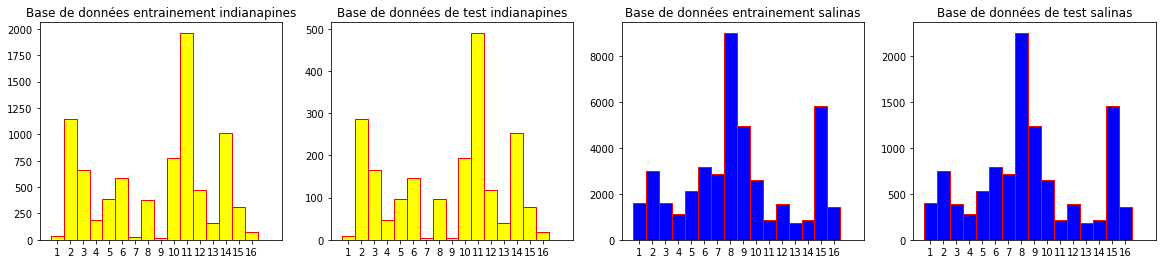

In [25]:
# Visualisation de la répartition des données pour l'entraînement
plt.figure(figsize=(20,4))
tab = [0.5, 1.5, 2.5, 3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5,15.5,16.5, 17.5]

ax = plt.subplot(1,4,1)
plt.hist(y_train, bins=tab, range=(0,2000), color='yellow', edgecolor='red')
plt.xticks(range(1,17), range(1,17))
plt.title('Base de données entrainement indianapines')

plt.subplot(1,4,2)
plt.hist(y_test, bins=tab, color='yellow', edgecolor='red')
plt.xticks(range(1,17), range(1,17))
plt.title('Base de données de test indianapines')

plt.subplot(1,4,3)
plt.hist(y_tr, bins=tab, color='blue', edgecolor='red')
plt.xticks(range(1,17), range(1,17))
plt.title('Base de données entrainement salinas')

plt.subplot(1,4,4)
plt.hist(y_te, bins=tab, color='blue', edgecolor='red')
plt.xticks(range(1,17), range(1,17))
plt.title('Base de données de test salinas')

# <font color='red'>3 - </font> Entraînements supervisés

In [26]:
def confusionMatrix(y_test, y_pred, dictionnary):
    '''
    paramètres:
        y_test: la valeur du set de test
        y_pred: la valeur du set de prédictions
        dictionnary: le dictionnaire des champs de notre image (nom et nombre d'échantillons)
    retourne:
        La matrice de confusion en joli
    '''
    # On utilise la fonction "confusion_matrix" de sklearn
    data = confusion_matrix(y_test, y_pred)
    
    # On récupère les noms de tous les champs depuis le dictionnaire
    names = list(dictionnary.keys())
    
    # On crée un tableau Pandas depuis la matrice de confusion, utilisant les noms du dictionnaire comme le nom des colonnes et des indexs
    df_cm = pd.DataFrame(data, columns = np.unique(names), index = np.unique(names))
    df_cm.index.name = 'Réelle'
    df_cm.columns.name = 'Prédite'
    plt.figure(figsize = (10,10))
    
    # On utilise la fonction "heatmap" de Seaborn pour rendre le tout joli
    sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
    
    # On affiche notre magnifique matrice
    plt.show()

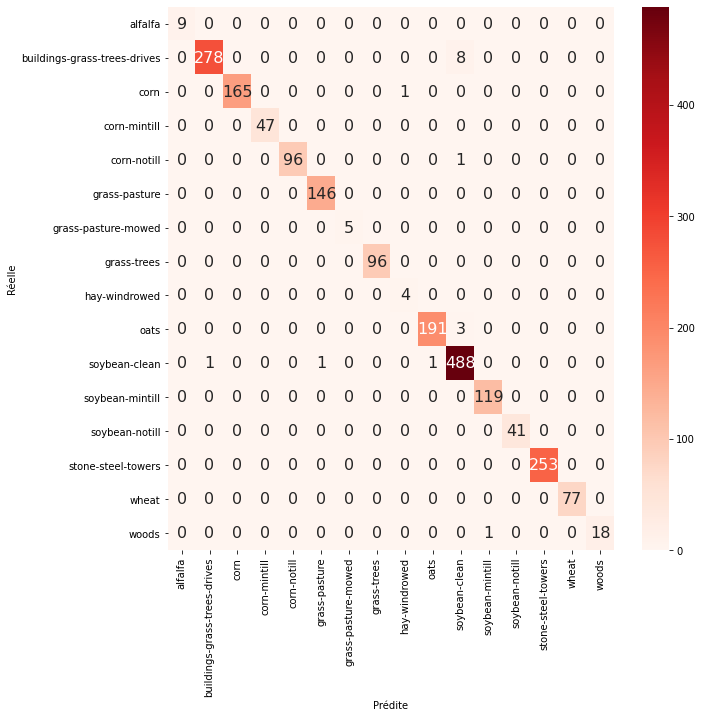

RandomForestClassifier 0.9917073170731707


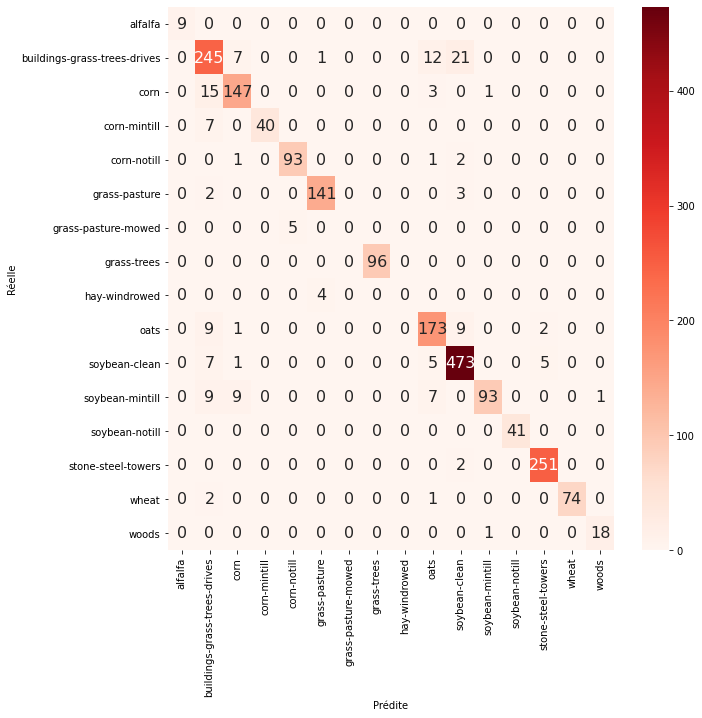

SVC 0.9239024390243903


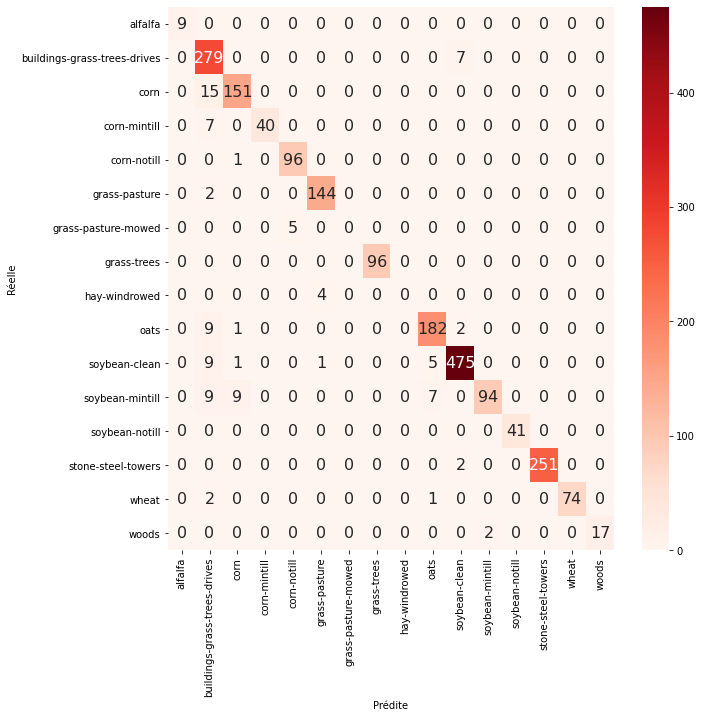

VotingClassifier 0.9507317073170731


In [27]:
rnd_clf = RandomForestClassifier()

svm_clf = SVC(C = 100, kernel = 'rbf', cache_size = 10*1024)

voting_clf = VotingClassifier(
    estimators = [('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

classifiers = [rnd_clf, svm_clf, voting_clf]
cm = []
for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    confusionMatrix(y_test, y_pred, indianapines_dict)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

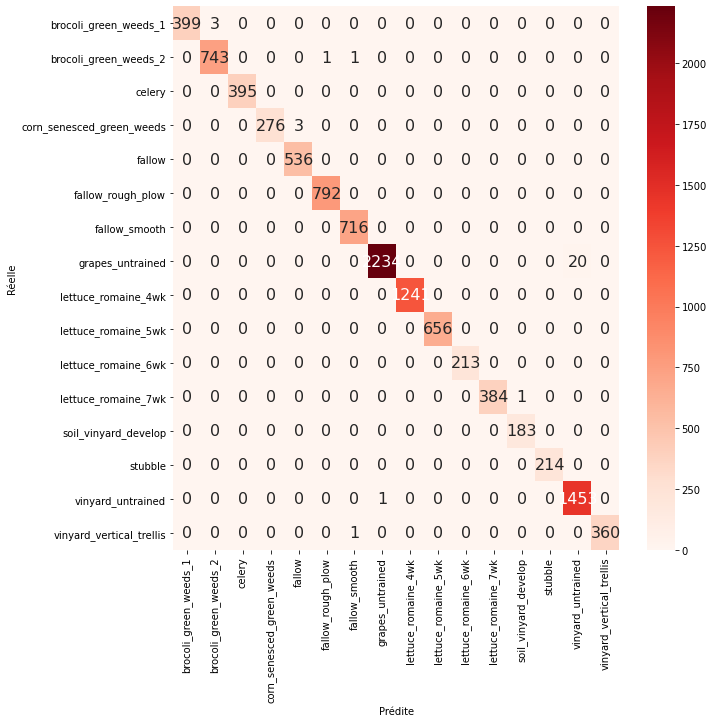

RandomForestClassifier 0.9971365231849252


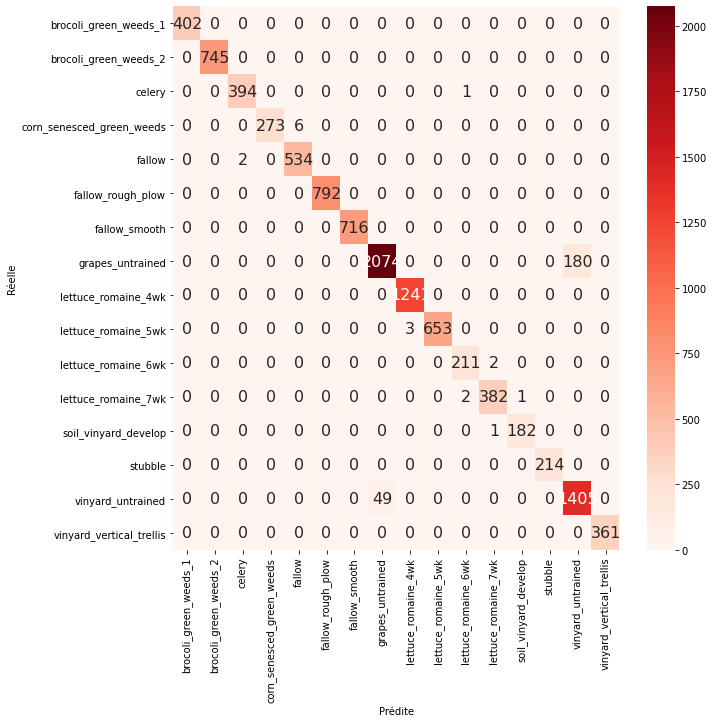

SVC 0.9771845556992426


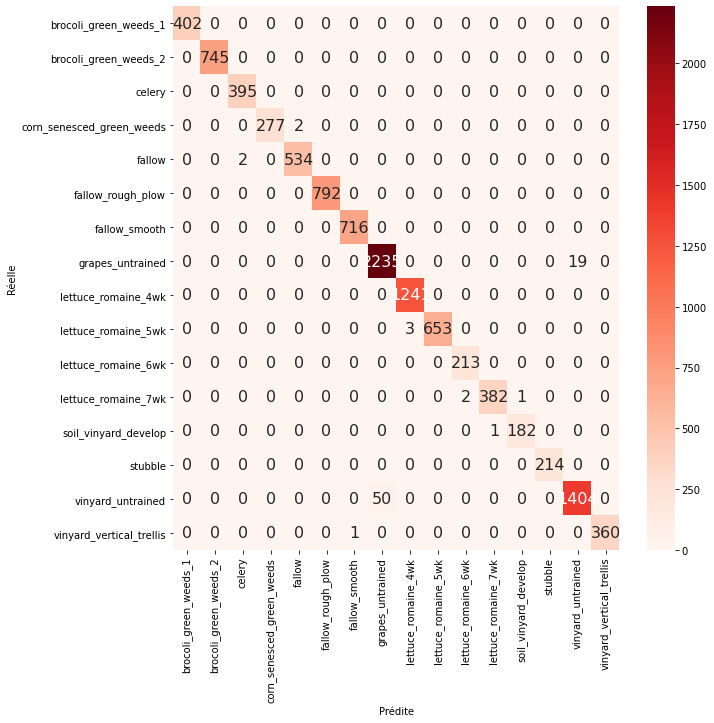

VotingClassifier 0.9925180121928691


In [28]:
rnd_clf_ = RandomForestClassifier()

svm_clf_ = SVC(C = 100, kernel = 'rbf', cache_size = 10*1024)

voting_clf_ = VotingClassifier(
    estimators = [('rf', rnd_clf_), ('svc', svm_clf_)],
    voting='hard')

classifiers_salinas = [rnd_clf_, svm_clf_, voting_clf_]
for clf in classifiers_salinas:
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)
    confusionMatrix(y_te, y_pred, salinas_dict)
    print(clf.__class__.__name__, accuracy_score(y_te, y_pred))

##  <font color='red'>3-1</font> Résultats à obtenir

In [29]:
from matplotlib.patches import Patch

def imshow_overlay(fig, base, overlay, labels=None):
    """Affiche les résultats par-dessus l'image de base avec des annotations optionnelles
    
    Paramètres
    ---------
    fig
        La figure à utiliser pour afficher l'image
    base
        Les données correspondant à l'image de base
    overlay
        Les données correspondant aux résultats affichés
        par-dessus l'image de base
    labels
        Les labels à utiliser pour annoter l'image
    
    Retourne
    -------
    Une liste de légendes correspondant aux résultats affichés
    """
    fig.imshow(base, cmap=plt.cm.gray)
    im = fig.imshow(overlay, cmap=plt.cm.nipy_spectral, alpha=0.5, interpolation='none')
    
    if not labels:
        return []
    
    values = np.unique(overlay.ravel())
    colors = [im.cmap(im.norm(value)) for value in values]
    return [Patch(color=color, label=label) for color, label in zip(colors, labels)]

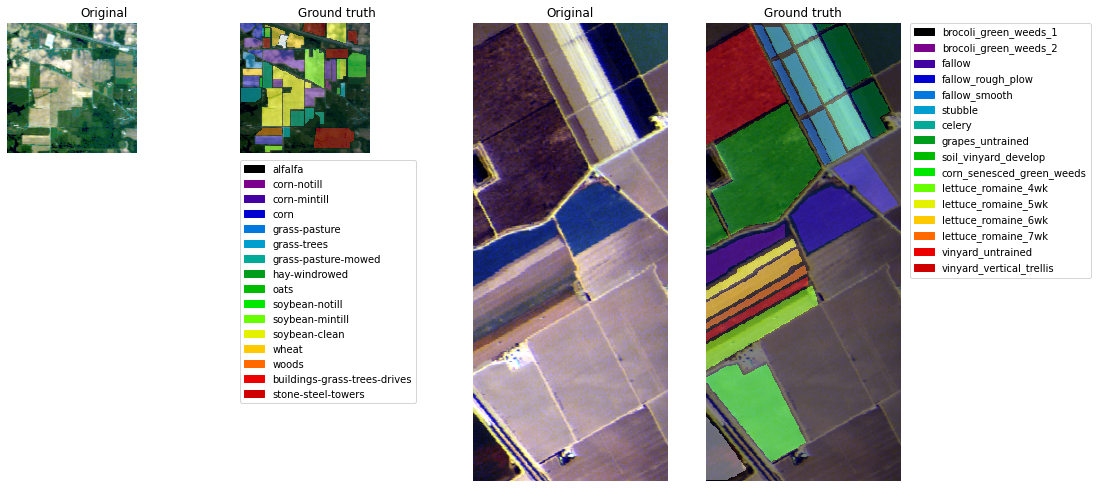

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 16),
                         sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(indianapines_pimped, cmap=plt.cm.gray)
ax[0].set_title("Original")

patches = imshow_overlay(ax[1], indianapines_pimped, indianapines_gt, indianapines_dict)
ax[1].legend(handles=patches, bbox_to_anchor=(0, 0.7), loc=2, borderaxespad=0)
ax[1].set_title("Ground truth")

ax[2].imshow(salinas_pimped, cmap=plt.cm.gray)
ax[2].set_title("Original")

patches = imshow_overlay(ax[3], salinas_pimped, salinas_gt, salinas_dict)
ax[3].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
ax[3].set_title("Ground truth")

for a in ax:
    a.axis('off')

plt.show()

In [31]:
def predictGroundTruth(pixelsPCA, clf):
    '''
    paramètres:
        pixelsPCQ: les pixels après application de la PCA
        clf: le classifier à utiliser
    retourne:
        La vérité terrain prédite, en excluant les pixels n'appartenant pas à une classe
    '''
    predict_ground_truth = np.zeros(pixelsPCA.shape[0])
    for i in range(pixelsPCA.shape[0]):
        # Si la classe du pixel est 0, le pixel n'appartient pas à une classe
        if pixelsPCA.iloc[i, -1] != 0:
            predict_ground_truth[i] = (clf.predict(pixelsPCA.iloc[i, :-1].values.reshape(1, -1)))
    return predict_ground_truth

##  <font color='red'>3-2</font> Résultats obtenus

In [32]:
def report_timings(it):
    """Retourne les résulats et le temps pris par chaque itération."""
    results = []
    timings = []
    
    end = datetime.now()
    start = end
    
    for result in it:
        end = datetime.now()
        results.append(result)
        timings.append([end - start])
        start = end
    
    return results, pd.DataFrame(timings, columns=["Timing"])

In [ ]:
classifiers = [svm_clf, rnd_clf, voting_clf]
classifiers_ = [svm_clf_, rnd_clf_, voting_clf_]

indianapines_res, indianapines_timings = report_timings(predictGroundTruth(df_indianapines, clf) for clf in classifiers)
salinas_res, salinas_timings = report_timings(predictGroundTruth(df_salinas, clf) for clf in classifiers_)

indianapines_timings["Classifier"] = [clf.__class__.__name__ for clf in classifiers]
indianapines_timings["Image"] = ["Indiana pines"] * 3
salinas_timings["Classifier"] = [clf.__class__.__name__ for clf in classifiers_]
salinas_timings["Image"] = ["Salinas"] * 3

pd.concat([indianapines_timings, salinas_timings]).set_index(["Classifier", "Image"])

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 16),
                         sharex=True, sharey=True)

for i in range(len(indianapines_res)):
    indianapines_res[i] = indianapines_res[i].reshape((145, 145)).astype('float')

ax = axes.ravel()

ax[0].imshow(indianapines_pimped, cmap=plt.cm.gray)
ax[0].set_title("Original")

imshow_overlay(ax[1], indianapines_pimped, indianapines_res[0])
y_pred = svm_clf.predict(X_test)
ax[1].set_title("SVM, acc = " + str(round(accuracy_score(y_test, y_pred), 2)))

imshow_overlay(ax[2], indianapines_pimped, indianapines_res[1])
y_pred = rnd_clf.predict(X_test)
ax[2].set_title("Random Forest, acc = " + str(round(accuracy_score(y_test, y_pred), 2)))

patches = imshow_overlay(ax[3], indianapines_pimped, indianapines_res[2], labels=indianapines_dict)
y_pred = voting_clf.predict(X_test)
ax[3].set_title("Voting Classifier, acc = "+ str(round(accuracy_score(y_test, y_pred), 2)))

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 16),
                         sharex=True, sharey=True)

for i in range(len(indianapines_res)):
    salinas_res[i] = salinas_res[i].reshape((salinas.shape[0], salinas.shape[1])).astype('float')

ax = axes.ravel()

ax[0].imshow(salinas_pimped, cmap=plt.cm.gray)
ax[0].set_title("Original")

imshow_overlay(ax[1], salinas_pimped, salinas_res[0])
y_pred = svm_clf_.predict(X_te)
ax[1].set_title("SVM, acc = " + str(round(accuracy_score(y_te, y_pred), 2)))

imshow_overlay(ax[2], salinas_pimped, salinas_res[1])
y_pred = rnd_clf_.predict(X_te)
ax[2].set_title("Random Forest, acc = " + str(round(accuracy_score(y_te, y_pred), 2)))

patches = imshow_overlay(ax[3], salinas_pimped, salinas_res[2], labels=salinas_dict)
y_pred = voting_clf_.predict(X_te)
ax[3].set_title("Voting Classifier, acc = "+ str(round(accuracy_score(y_te, y_pred), 2)))

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 16),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(indianapines_gt, cmap=plt.cm.nipy_spectral)
ax[0].set_title("Ground Truth")

ax[1].imshow(indianapines_res[2], cmap=plt.cm.nipy_spectral)
ax[1].set_title("Random Forest")

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 16),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(salinas_gt, cmap=plt.cm.nipy_spectral)
ax[0].set_title("Ground Truth")

ax[1].imshow(salinas_res[1].reshape(salinas.shape[0], salinas.shape[1]), cmap=plt.cm.nipy_spectral)
ax[1].set_title("Random Forest")

##  <font color='red'>3-3</font> Morphologie mathématique

In [ ]:
# Enlève du bruit en utilisant la magie de la morphologie mathématiques
def remove_noise(image):
    '''
    paramètres:
        image: L'image à partir de laquelle on veut supprimer du bruit
    retourne:
        L'image légèrement transformée
    '''
    return skimage.morphology.opening(skimage.morphology.closing(image, skimage.morphology.square(2)), skimage.morphology.square(1))

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 16),
                         sharex=True, sharey=True)
ax = axes.ravel()

classifier = [svm_clf, rnd_clf, voting_clf]

ax[0].imshow(indianapines_pimped, cmap=plt.cm.gray)
ax[0].set_title("Original")

imshow_overlay(ax[1], indianapines_pimped, remove_noise(indianapines_res[0]))
ax[1].set_title("Morpho SVM")

imshow_overlay(ax[2], indianapines_pimped, remove_noise(indianapines_res[1]))
ax[2].set_title("Morpho Random Forest")

patches = imshow_overlay(ax[3], indianapines_pimped, remove_noise(indianapines_res[2]), labels=indianapines_dict)
ax[3].set_title("Morpho Voting Classifier")

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 16),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(salinas_pimped, cmap=plt.cm.gray)
ax[0].set_title("Original")

imshow_overlay(ax[1], salinas_pimped, remove_noise(salinas_res[0]))
ax[1].set_title("Morpho SVM")

imshow_overlay(ax[2], salinas_pimped, remove_noise(salinas_res[1]))
ax[2].set_title("Morpho Random Forest")

patches = imshow_overlay(ax[3], salinas_pimped, remove_noise(salinas_res[2]), labels=salinas_dict)
ax[3].set_title("Morpho Voting Classifier")

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()